# Preprocessing: transform categorical data
by Claudio Sartori

In `scikit-learn` the classifiers require numeric data. The library makes available a set of preprocessing fuctions which help the transformation. This exercise proposes two types of transformations:

- `OneHotEncoder` for purely categorical columns: if the column has **V** distinct values it is substituted by **V** binary columns where in each row only the bit corrosponding to the original value is true
- `OrdinalEncoder` for ordinal columns: the original **V** values are mapped into the **0..V-1** range

The additional function `ColumnTransformer` allows to apply the different transformations to the appropriate columns with a single statement.

### To do:
- import the appropriate names
- set the random state
- import the data set with the appropriate column names
- inspect the content and the data types
- read carefully the `.names` file of the data set, to understand which are the ordinal and categorical data
- data cleaning
    - the **ordinal transformer** generates a mapping from strings to numbers according to the lexicographic sorting of the strings; in this particular case, the strings indicate numeric subranges, and ranges with one digit constitute exceptions
        '5-9' happens to be after '20-25'
    - it is necessary to transform '5-9' into '05-09', and the same for other similar cases
    - a way to do this is to prepare dictionaries for the translation and use the `.map` function
- prepare the lists of the ordinal, categorical and numeric columns
- prepare the preprocessor
- split the cleaned data into the X and y part
- fit_transform the preprocessor and generate the transformed data set
- split the transformed data set into train and test
- use the same method used for the exercise of 19/11 to test several classifiers

In [1]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

print(__doc__) # print information included in the triple quotes at the beginning

random_state = 42


http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori



In [2]:
# url = 'diagnosis.data'
# names = ['Temp', 'Nau', 'Lum', 'Uri', 'Mic', 'Bur', 'd1', 'd2']
# sep = "\t"
url = 'breast-cancer.data'
names = ['Class','age','menopause','tumor-size','inv-nodes',
         'node-caps','deg-malig','breast','breast-quad','irradiat']
sep = ","

df = pd.read_csv(url, names = names, sep=sep)
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


Show the types of the columns

In [3]:
print(df.dtypes)

Class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object


Clean the column `tumor-size`

In [4]:
tumor_size_dict = dict(zip(list(df['tumor-size'].unique()),list(df['tumor-size'].unique())))
tumor_size_dict

{'30-34': '30-34',
 '20-24': '20-24',
 '15-19': '15-19',
 '0-4': '0-4',
 '25-29': '25-29',
 '50-54': '50-54',
 '10-14': '10-14',
 '40-44': '40-44',
 '35-39': '35-39',
 '5-9': '5-9',
 '45-49': '45-49'}

In [5]:
tumor_size_dict['0-4'] = '00-04'
tumor_size_dict['5-9'] = '05-09'

In [6]:
df['tumor-size'] = df['tumor-size'].map(tumor_size_dict)


Clean the column `inv-nodes`

In [7]:
inv_nodes_dict = dict(zip(list(df['inv-nodes'].unique()),list(df['inv-nodes'].unique())))
print(inv_nodes_dict)

{'0-2': '0-2', '6-8': '6-8', '9-11': '9-11', '3-5': '3-5', '15-17': '15-17', '12-14': '12-14', '24-26': '24-26'}


In [8]:
inv_nodes_dict['0-2']  = '00-02'
inv_nodes_dict['3-5']  = '03-05'
inv_nodes_dict['6-8']  = '06-08'
inv_nodes_dict['9-11'] = '09-11'

In [9]:
df['inv-nodes'] = df['inv-nodes'].map(inv_nodes_dict)

Inspect the data

In [10]:
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,00-02,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,00-02,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,00-02,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,00-02,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,00-04,00-02,no,2,right,right_low,no


Prepare the lists of numeric features, ordinal features, categorical features

In [11]:
non_numerical = df.dtypes.loc[df.dtypes == 'object'].index.values
print(non_numerical)

['Class' 'age' 'menopause' 'tumor-size' 'inv-nodes' 'node-caps' 'breast'
 'breast-quad' 'irradiat']


In [12]:
numeric_features = df.dtypes.loc[df.dtypes != 'object'].index.values;
print(numeric_features)

['deg-malig']


In [13]:
ordinal_features =['age', 'tumor-size', 'inv-nodes']
print(ordinal_features)

['age', 'tumor-size', 'inv-nodes']


In [14]:
categorical_features = list(set(non_numerical)-set(ordinal_features)-set(['Class']))
print(categorical_features)

['menopause', 'breast', 'node-caps', 'irradiat', 'breast-quad']


Prepare the transformer

In [15]:
# transf_dtype = np.float64
transf_dtype = np.int32

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse = False, dtype = transf_dtype)
ordinal_transformer = OrdinalEncoder(dtype = transf_dtype)
preprocessor = ColumnTransformer(
    transformers = [('cat', categorical_transformer, categorical_features),
                    ('ord', ordinal_transformer, ordinal_features)
                   ],
                    remainder = 'passthrough'
    )

Split X and y and check the shapes

In [16]:
X = df.drop(['Class'],axis=1);
Y = df['Class'];

print('\nX shape: {}\nY shape: {}'.format(X.shape,Y.shape))


X shape: (286, 9)
Y shape: (286,)


Fit the preprocessor with X and check the parameters printing the `.named_transformers_` attribute

In [17]:
preprocessor.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(dtype=<class 'numpy.int32'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['menopause', 'breast', 'node-caps',
                                  'irradiat', 'breast-quad']),
                                ('ord',
                                 OrdinalEncoder(dtype=<class 'numpy.int32'>),
                                 ['age', 'tumor-size', 'inv-nodes'])])

In [18]:
print(preprocessor.named_transformers_)

{'cat': OneHotEncoder(dtype=<class 'numpy.int32'>, handle_unknown='ignore',
              sparse=False), 'ord': OrdinalEncoder(dtype=<class 'numpy.int32'>), 'remainder': 'passthrough'}


Fit-transform X and store the result in X_p, check the shape

In [19]:
X_p = preprocessor.fit_transform(X)

In [20]:
print(X_p.shape)

(286, 20)


For ease of inspection transform `X_p` into a data frame `df_p` and inspect it

In [21]:
df_p = pd.DataFrame(X_p)
df_p.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,6,0,3
1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,2,4,0,2
2,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,2,4,0,2
3,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,4,3,0,2
4,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,2,0,0,2


In [22]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       286 non-null    int64
 1   1       286 non-null    int64
 2   2       286 non-null    int64
 3   3       286 non-null    int64
 4   4       286 non-null    int64
 5   5       286 non-null    int64
 6   6       286 non-null    int64
 7   7       286 non-null    int64
 8   8       286 non-null    int64
 9   9       286 non-null    int64
 10  10      286 non-null    int64
 11  11      286 non-null    int64
 12  12      286 non-null    int64
 13  13      286 non-null    int64
 14  14      286 non-null    int64
 15  15      286 non-null    int64
 16  16      286 non-null    int64
 17  17      286 non-null    int64
 18  18      286 non-null    int64
 19  19      286 non-null    int64
dtypes: int64(20)
memory usage: 44.8 KB


The columns in the transformed dataset are generated according to the order you see printing the preprocessor after fitting, therefore the last four columns correspond to `'age', 'tumor-size', 'inv-nodes', 'deg-malig'`.

In order to inspect if the translation and check if the mapping is as expected, compare the sorted values of df['tumor-size'] and df_p[17], e.g. comparing the index sequences

In [23]:
C = df['age'].compare(df_p[16])
C.head()

,self,other
0,30-39,1
1,40-49,2
2,40-49,2
3,60-69,4
4,40-49,2


In [24]:
CC = df['tumor-size'].compare(df_p[17])
CC.head()

,self,other
0,30-34,6
1,20-24,4
2,20-24,4
3,15-19,3
4,00-04,0


In [25]:
CCC = df['inv-nodes'].compare(df_p[18])
CCC.head()

,self,other
0,00-02,0
1,00-02,0
2,00-02,0
3,00-02,0
4,00-02,0


Train/test split

In [26]:
Xtr, Xts, Ytr, Yts = train_test_split(X_p, Y);

print('\n training X : {}\n testing X : {}\n training Y : {}\n testing Y : {}'.format(Xtr.shape, Xts.shape, Ytr.shape, Yts.shape))


 training X : (214, 20)
 testing X : (72, 20)
 training Y : (214,)
 testing Y : (72,)


Classification and test


In [35]:
# Set the parameters to be explored by the grid for each classifier
tuned_param_dt = [{'max_depth': list(range(1,20))}]
tuned_param_nb = [{'var_smoothing': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-07, 1e-8, 1e-9, 1e-10]}]
tuned_param_lp = [{'early_stopping': [True]}]
tuned_param_svc = [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100, 1000],
                    },
                   ]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
tuned_param_rfc =[{'max_depth': list(range(1,11))}]
tuned_param_ada = [{'learning_rate': [1., 0.1, 0.01, 0.001, 0.0001]}]
# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(criterion="gini",random_state=0),
           'param': tuned_param_dt,
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': tuned_param_nb
          },
    'lp': {'name': 'Linear Perceptron',
           'estimator': Perceptron(),
           'param': tuned_param_lp,
          },
    'svc':{'name': 'Support Vector',
           'estimator': SVC(),
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn},
    'rfc':{'name': 'Random Forest',
           'estimator': RandomForestClassifier(),
           'param': tuned_param_rfc
          },
    'ada':{'name': 'Adaboost            ',
           'estimator': AdaBoostClassifier(),
           'param': tuned_param_ada
          }

}

In [36]:
scores = {}
for m in models:
    print(models[m]['name'])
    clf = models[m]['estimator'];
    clf.fit(Xtr,Ytr);
    Yts_pred = clf.predict(Xts);
    scores[m] = accuracy_score(Yts,Yts_pred);
    print(classification_report(Yts,Yts_pred))

Decision Tree
                      precision    recall  f1-score   support

no-recurrence-events       0.85      0.78      0.81        58
   recurrence-events       0.32      0.43      0.36        14

            accuracy                           0.71        72
           macro avg       0.58      0.60      0.59        72
        weighted avg       0.75      0.71      0.72        72

Gaussian Naive Bayes
                      precision    recall  f1-score   support

no-recurrence-events       0.85      0.88      0.86        58
   recurrence-events       0.42      0.36      0.38        14

            accuracy                           0.78        72
           macro avg       0.63      0.62      0.62        72
        weighted avg       0.77      0.78      0.77        72

Linear Perceptron
                      precision    recall  f1-score   support

no-recurrence-events       0.83      0.98      0.90        58
   recurrence-events       0.67      0.14      0.24        14

         

{'dt': 0.7083333333333334, 'nb': 0.7777777777777778, 'lp': 0.8194444444444444, 'svc': 0.8472222222222222, 'knn': 0.7638888888888888, 'rfc': 0.7222222222222222, 'ada': 0.7777777777777778}


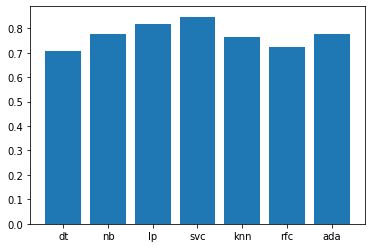

In [37]:
names = list(scores.keys())
values = list(scores.values())
print(scores)
plt.bar(range(len(scores)), values, tick_label=names)
plt.show()
